In [1]:
import spacy, stanza
import pandas as pd
import langid
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


In [2]:
# Load data
data = pd.read_csv('../../data/csv/data.csv')

In [3]:
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

nlp_ar = stanza.Pipeline(lang='ar') # Arabic

2024-05-01 15:13:48 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-01 15:13:48 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-01 15:13:49 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-01 15:13:49 INFO: Using device: cpu
2024-05-01 15:13:49 INFO: Loading: tokenize
2024-05-01 15:13:49 INFO: Loading: mwt
2024-05-01 15:13:49 INFO: Loading: pos
2024-05-01 15:13:49 INFO: Loading: lemma
2024-05-01 15:13:49 INFO: Loading: depparse
2024-05-01 15:13:50 INFO: Loading: ner
2024-05-01 15:13:50 INFO: Done loading processors!


In [4]:
def tokenize(text: str, lang: str) -> list:
    """
    Permet de tokeniser un texte en fonction de la langue

    Parameters:
    text (str): le texte à tokeniser
    lang (str): la langue du texte

    Returns:
    list: une liste de tokens
    """
    if lang == 'ar':
        doc = nlp_ar(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [token.text for token in doc]

**Tokenisation** : 
- Chaque document est tokenisé selon la langue à l'aide des modèles de NLP correspondants. Les tokens sont les mots dans le cas des langues occidentales et des unités plus complexes pour des langues comme le chinois ou le japonais.

In [19]:
def get_stats(data: pd.DataFrame) -> pd.DataFrame:
    """
    Permet de calculer des statistiques sur les données

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    pd.DataFrame: les statistiques calculées
        n_lang: le nombre de langues
        n_text: le nombre de textes
        n_text_per_lang: le nombre de textes par langue
        mean_tokens_per_text: le nombre moyen de tokens par texte
        n_text_under_100_chars: le nombre de textes de moins de 100 caractères par langue
        ratio_text_under_100_tokens: le ratio de textes de moins de 100 tokens par langue
    """
    languages = defaultdict()
    tokens = defaultdict()
    for i, row in data.iterrows():
        lang = row['Label']
        text = row['Text']
        if lang not in languages:
            languages[lang] = 0
            tokens[lang] = 0
        languages[lang] += 1
        tokens[lang] += len(tokenize(text, lang))

    # Initialisation du dictionnaire pour les statistiques
    stats = defaultdict()

    # Calcul du nombre total de langues
    stats['n_lang'] = len(languages)

    # Calcul du nombre total de textes
    stats['n_text'] = sum(languages.values())

    # Nombre de textes par langue
    stats['n_text_per_lang'] = {}
    for lang in languages:
        stats['n_text_per_lang'][lang] = languages[lang]

    # Nombre moyen de tokens par texte pour chaque langue
    stats['mean_tokens_per_text'] = {}
    for lang in languages:
        stats['mean_tokens_per_text'][lang] = tokens[lang] / languages[lang]

    # Nombre de textes de moins de 100 caractères par langue
    stats['n_text_under_100_tokens'] = {}
    for lang in languages:
        # Initialiser à 0 pour chaque langue
        stats['n_text_under_100_tokens'][lang] = 0
        # Parcourir les données et accumuler le nombre de textes courts
        for i, row in data[data['Label'] == lang].iterrows():
            if len(row['Text']) < 100:
                stats['n_text_under_100_tokens'][lang] += 1

    # Ratio de textes de moins de 100 tokens par langue
    stats['ratio_text_under_100_tokens'] = {}
    for lang in languages:
        # Calculer le nombre total de textes courts en tokens pour chaque langue
        short_texts = 0
        for i, row in data[data['Label'] == lang].iterrows():
            if len(tokenize(row['Text'], lang)) < 100:
                short_texts += 1
        # Calculer le ratio pour chaque langue
        stats['ratio_text_under_100_tokens'][lang] = short_texts / languages[lang] if languages[lang] > 0 else 0

    df_stats = pd.DataFrame({
        "n_text_per_lang": stats['n_text_per_lang'],
        "mean_tokens_per_text": stats['mean_tokens_per_text'],
        "n_text_under_100_tokens": stats['n_text_under_100_tokens'],
        "ratio_text_under_100_tokens": stats['ratio_text_under_100_tokens']
    })

    df_stats["n_lang"] = stats['n_lang']
    df_stats["n_text"] = stats['n_text']

    return df_stats

In [20]:
df = get_stats(data)
print(df)

    n_text_per_lang  mean_tokens_per_text  n_text_under_100_tokens  \
ko              120             31.125000                       54   
ar               21             80.333333                        2   
fr              469             51.944563                       14   
zh              192             51.385417                      127   
es              165             46.096970                        8   
ru              587             34.681431                       81   
de              334             29.526946                       62   
ja              186             62.548387                       94   
en              546             51.487179                       11   

    ratio_text_under_100_tokens  n_lang  n_text  
ko                     1.000000       9    2620  
ar                     0.666667       9    2620  
fr                     0.974414       9    2620  
zh                     0.963542       9    2620  
es                     0.981818       9    2620  

In [21]:
def calculate_metrics(data: pd.DataFrame) -> dict:
    """
    Calcule les métriques de diversité lexicale pour chaque langue ainsi que la moyenne globale de tokens par texte 

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    dict: un dictionnaire contenant les métriques
        Average Words per Sample (float): le nombre moyen de tokens par texte
        Lexical Diversity (float): la diversité lexicale
    """

    language_data = defaultdict(list)

    for index, row in data.iterrows():
        tokens = tokenize(row['Text'], row['Label'])
        language_data[row['Label']].append(tokens)
    
    results = {}

    for lang, tokens_list in language_data.items():
        total_words = sum(len(tokens) for tokens in tokens_list)
        total_samples = len(tokens_list)
        unique_words = len(set(word for tokens in tokens_list for word in tokens))
        
        average_words_per_sample = total_words / total_samples if total_samples else 0
        lexical_diversity = unique_words / total_words if total_words else 0

        results[lang] = {
            'Average Words per Sample': average_words_per_sample,
            'Lexical Diversity': lexical_diversity
        }
        results = pd.DataFrame(results)

    return results

**Métriques calculées** :
- **Moyenne des mots par échantillon** : Cela donne une idée de la longueur moyenne des textes pour chaque langue.
- **Diversité lexicale** : C'est le rapport entre le nombre de mots uniques et le nombre total de mots dans les échantillons de chaque langue. Une valeur plus élevée indique une plus grande richesse lexicale.

In [22]:
# Compute metrics
metrics = calculate_metrics(data)

# Display the metrics
print(metrics)


                                 ko         ar         fr         zh  \
Average Words per Sample  31.125000  80.333333  51.944563  51.385417   
Lexical Diversity          0.628648   0.490219   0.220795   0.303771   

                                 es         ru         de         ja  \
Average Words per Sample  46.096970  34.681431  29.526946  62.548387   
Lexical Diversity          0.336708   0.350084   0.339181   0.222365   

                                 en  
Average Words per Sample  51.487179  
Lexical Diversity          0.206175  


**Affichage des Résultats** : 
- Les résultats sont stockés dans un dictionnaire et imprimés. Vous pouvez également les visualiser en utilisant matplotlib ou une autre bibliothèque de visualisation pour mieux comprendre les distributions.

**1. Coréen (ko)** : Le coréen a un nombre moyen de mots par échantillon de 31.125 et une diversité lexicale de 0.629. Cette diversité élevée indique une grande variété de mots utilisés dans des textes relativement courts.

**2. Arabe (ar)** : L'arabe présente une moyenne de 80.33 mots par échantillon avec une diversité lexicale de 0.490. Ce chiffre suggère un usage assez varié du vocabulaire.

**3. Français (fr)** : Avec une moyenne de 51.94 mots par échantillon et une diversité lexicale de 0.221, le français montre une utilisation relativement répétitive du vocabulaire dans des textes courts.

**4. Chinois (zh)** : Le chinois affiche une moyenne de 51.38 mots par échantillon et une diversité lexicale de 0.304. Cette mesure reflète l'efficacité dans l'utilisation d'un vocabulaire varié dans des textes de longueur modérée.

**5. Espagnol (es)** : L'espagnol a une moyenne de 46.10 mots par échantillon avec une diversité lexicale de 0.337. Ces valeurs indiquent un bon équilibre entre la longueur des textes et la variété du vocabulaire, ce qui peut signaler une tendance à une écriture descriptive tout en restant accessible.

**6. Russe (ru)** : Le russe, avec une moyenne de 34.68 mots et une diversité lexicale de 0.350, semble utiliser un vocabulaire riche dans des descriptions relativement courtes.

**7. Allemand (de)** : Avec une moyenne de 29.53 mots et une diversité lexicale de 0.339, l'allemand montre une utilisation variée du vocabulaire dans des textes courts.

**8. Japonais (ja)** : Le japonais a une moyenne de 62.55 mots par échantillon avec une diversité lexicale de 0.222. Ces valeurs suggèrent des textes plus longs avec une utilisation répétitive de certains termes.

**9. Anglais (en)** : L'anglais affiche un nombre moyen de mots de 51.49 par échantillon avec la diversité lexicale la plus basse à 0.206. Ceci indique une tendance à des textes concis avec une utilisation limitée de vocabulaire diversifié.

In [23]:
def detect_language(text: str) -> str:
    """ 
    Detecte la langue d'un texte

    Parameters:
    text (str): le texte à analyser

    Returns:
    str: la langue du texte
    """
    lang, _ = langid.classify(text) 
    return lang


def calculate_precision_recall_f1(predictions: list, true_labels: list) -> pd.DataFrame:
    """
    Calcule les métriques de précision, rappel et f1-score

    Parameters:
    predictions (list): les prédictions
    true_labels (list): les vraies étiquettes

    Returns:
    pd.DataFrame: un DataFrame contenant les métriques
    """
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average=None, labels=list(set(true_labels)))
    metrics = pd.DataFrame({
        'Language': list(set(true_labels)),
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })
    return metrics

def cross_validate_language_detection(data: str, n_splits=5) -> list:
    """
    Réalise une validation croisée pour la détection de la langue des textes

    Parameters:
    data (pd.DataFrame): les données
    n_splits (int): le nombre de splits

    Returns:
    list: une liste de résultats
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    results = []

    for train_index, test_index in kf.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]
        test_predictions = test_data['Text'].apply(detect_language)
        test_metrics = calculate_precision_recall_f1(test_predictions, test_data['Label'])
        results.append(test_metrics)

    return results


1. **detect_language** : J'utilise la fonction `classify` de `langid` pour identifier la langue d'un texte. Cette méthode renvoie la langue prédite et un score de confiance, mais je ne retiens que la langue.
   
2. **calculate_precision_recall_f1** : Après avoir fait des prédictions sur un ensemble de données, je calcule les métriques standard pour l'évaluation de la classification - précision, rappel, et le score F1 pour chaque langue présente dans l'ensemble des étiquettes vraies. Ces résultats sont ensuite stockés et renvoyés sous forme de DataFrame pour une analyse plus facile.

3. **cross_validate_language_detection** : Pour valider la fiabilité du modèle sur différentes partitions des données, je réalise une validation croisée. Le jeu de données est divisé en plusieurs sous-ensembles, et pour chaque sous-ensemble, je répète le processus de prédiction et de calcul des métriques. Tous les résultats de chaque pli sont accumulés et retournés pour un examen ultérieur.

In [24]:
train_data = data.sample(frac=0.7, random_state=1)  # 70% of data for training
test_data = data.drop(train_data.index)


cross_val_results = cross_validate_language_detection(test_data)

for idx, result in enumerate(cross_val_results):
    print(f"Results for fold {idx + 1}:")
    print(result)
    print("\n")

Results for fold 1:
  Language  Precision    Recall  F1-score
0       en        1.0  1.000000  1.000000
1       ja        1.0  1.000000  1.000000
2       ru        1.0  0.971429  0.985507
3       zh        1.0  1.000000  1.000000
4       es        1.0  1.000000  1.000000
5       fr        1.0  1.000000  1.000000
6       de        1.0  1.000000  1.000000
7       ko        1.0  1.000000  1.000000
8       ar        1.0  1.000000  1.000000


Results for fold 2:
  Language  Precision    Recall  F1-score
0       en   0.971429  1.000000  0.985507
1       ja   1.000000  1.000000  1.000000
2       ru   1.000000  1.000000  1.000000
3       zh   1.000000  1.000000  1.000000
4       es   1.000000  1.000000  1.000000
5       fr   1.000000  0.967742  0.983607
6       de   1.000000  1.000000  1.000000
7       ko   1.000000  1.000000  1.000000
8       ar   1.000000  1.000000  1.000000


Results for fold 3:
  Language  Precision  Recall  F1-score
0       en        1.0     1.0  1.000000
1       ja      

1. **Sélection des données pour l'entraînement** : Je commence par sélectionner aléatoirement 70% des données pour l'entraînement. Cela permet de s'assurer que le modèle est entraîné sur une grande partie des données disponibles, tout en laissant de côté 30% pour le test. L'utilisation de `random_state=1` garantit que la sélection est reproductible, ce qui signifie que nous obtiendrons le même ensemble d'entraînement à chaque fois que vous exécutez ce code.

2. **Préparation des données de test** : Les données restantes, qui ne sont pas incluses dans l'ensemble d'entraînement, sont utilisées comme ensemble de test. Cela permet de tester le modèle sur des données qu'il n'a jamais vues, fournissant ainsi une évaluation honnête de sa performance.

3. **Validation croisée sur l'ensemble de test** : La fonction `cross_validate_language_detection` est utilisée pour exécuter une validation croisée sur l'ensemble de test. Cela implique de diviser les données de test en plusieurs sous-ensembles (ou plis), d'entraîner le modèle sur certains sous-ensembles et de le tester sur les autres. Cela aide à évaluer la stabilité et la fiabilité du modèle en fournissant une mesure de sa performance sur différents segments des données de test.

4. **Affichage des résultats** : Les résultats de la validation croisée sont affichés pli par pli. Chaque résultat montre la précision, le rappel, et le score F1 pour chaque langue détectée dans le pli concerné. Cela permet de voir comment le modèle performe à travers différents sous-ensembles de données de test, donnant une vue d'ensemble de sa capacité à généraliser à de nouvelles données.

Ce processus est crucial pour s'assurer que le modèle de détection de langue fonctionne bien non seulement sur un ensemble de données spécifique mais aussi de manière plus générale sur des données variées. 

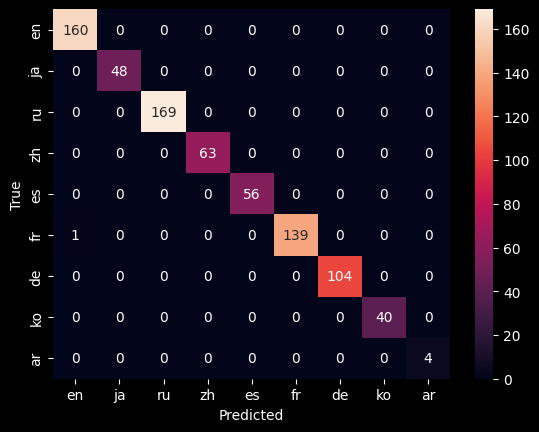

In [25]:
def plot_confusion_matrix(data: pd.DataFrame) -> None:
    """
    Plot the confusion matrix

    Parameters:
    data (pd.DataFrame): the data

    Returns:
    None
    """
    true_labels = data['Label'].tolist()
    predictions = data['Text'].apply(detect_language)
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predictions, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(test_data)  


Dans ce bloc de code, j'importe d'abord les bibliothèques nécessaires pour analyser et visualiser les données. `confusion_matrix` de `sklearn.metrics` me permet de calculer la matrice de confusion entre les étiquettes réelles et les prédictions. `seaborn` et `matplotlib.pyplot` sont utilisés pour la visualisation des données.

J'ai défini ensuite une fonction `plot_confusion_matrix`, qui prend comme argument les données contenant les textes et leurs étiquettes linguistiques réelles. La fonction applique d'abord la détection de langue à chaque texte pour obtenir les prédictions. Elle crée ensuite une matrice de confusion, qui compare les étiquettes réelles aux prédictions.

La matrice de confusion est visualisée sous forme de heatmap grâce à `seaborn.heatmap`. Chaque cellule de la heatmap représente le nombre de prédictions pour chaque combinaison d'étiquette réelle et prédite, permettant de voir facilement où le modèle performe bien et où il fait des erreurs. Les étiquettes des axes représentent les langues prédites (abscisses) et les langues réelles (ordonnées).

Enfin, j'exécute cette fonction en utilisant les données de test pour voir visuellement la performance du modèle sur ces données. Cette visualisation est cruciale pour comprendre les performances détaillées du modèle de détection de langue, notamment pour identifier les confusions spécifiques entre les langues.

Chaque ligne de la matrice représente les instances dans une classe réelle, tandis que chaque colonne représente les instances dans une classe prédite. Voici comment je comprends cette matrice :

1. **Valeurs Diagonales** : Ces valeurs (169 pour le russe, 139 pour le français, 104 pour l'allemand, 160 pour l'anglais, 40 pour le coréen, 63 pour le chinois, 48 pour le japonais, 56 pour l'espagnol, et 4 pour l'arabe) représentent le nombre de fois où le modèle a correctement prédit la langue. Ce sont ce qu'on appelle les vrais positifs.

2. **Valeurs Hors-Diagonale** : Ces valeurs montrent les moments où le modèle a prédit incorrectement la langue. Par exemple, il y a 1 cas où le français a été prédit incorrectement comme étant l'allemand, et 1 cas où le coréen a été prédit comme l'anglais.

3. **Intensité de Couleur** : L'échelle de couleur à droite indique le nombre d'instances, les couleurs plus foncées représentant des nombres plus élevés. Cela met visuellement en évidence les langues avec un plus grand nombre de prédictions correctes.

4. **Précision** : En général, le modèle montre une bonne précision pour la plupart des langues car les nombres les plus élevés sont situés le long de la diagonale. Cependant, l'arabe a un très faible nombre de prédictions correctes (4), suggérant des problèmes pour prédire cette langue avec précision, potentiellement en raison de données d'entraînement insuffisantes ou de biais inhérents du modèle contre les langues moins représentées dans l'ensemble des données.

Cette matrice est un outil utile pour identifier la performance globale du modèle et où il pourrait faire le plus d'erreurs, aidant ainsi à informer la formation et les ajustements futurs du modèle.